HW2 testing bench  

In [1]:
import numpy as np
import heapq as h
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pdb

In [2]:
class Function_node:
    #Globals to be inherited
    node_types = ('+','-','*','/','^','sin','cos','const','var','ERR')#last is the header indicator (indexing from 1!)
    
    def __init__(self, function_name, children=None, value=None):
             
        #assigning a name in our accepted list
        try:
            if function_name not in self.node_types:
                raise ValueError('"Invalid input. Please enter a valid node type \n\n\t run> heap.node_types for the list"')
            else:
                self.function_name = function_name
        except ValueError as err_msg: 
            #print(err_msg)
            self.function_name = 'ERROR'
            sys.exit() #exit if there is an issue
            
        
        self.children = children if children else []
        self.value = value
        
    def __str__(self): #print statement
        if  self.function_name  == 'const':
            return f"{self.value}"
        elif self.function_name == 'var':
            if self.value: return f"x={self.value}"
            else:return "X"
        
        else:
            return f"{self.function_name}"
    
    def __isnan__(self):
        return False     

In [3]:
# https://github.com/swacad/numpy-heap/blob/master/heap.py
#Starting at index 1~
class NP_Heap(Function_node): 
    def __init__(self,length = 2): 
        self.heap           = np.full(length,np.nan).astype(Function_node)
        self.operators      = ('+','-','*','/','^','sin','cos')
        self.trig_operators = ('sin','cos')


    
    def get_parent_idx(self, child_idx):
        return int(child_idx/2)

    def get_parent(self, child_idx):
        parent_idx = self.get_parent_idx(child_idx)
        return self.heap[parent_idx] 
    
    def get_left_child_idx(self, parent_idx):
        return 2 * parent_idx

    def get_right_child_idx(self, parent_idx):
        return 2 * parent_idx + 1

    def get_left_child(self, parent_idx):
        left_child = self.heap[self.get_left_child_idx(parent_idx)]
        return left_child

    def get_right_child(self, parent_idx):
        right_child = self.heap[self.get_right_child_idx(parent_idx)]
        return right_child

    def get_children_idx(self, parent_idx):
        return 2 * parent_idx, 2 * parent_idx + 1
    
    def get_children(self, parent_idx):
        child_1_idx, child_2_idx = self.get_children_idx(parent_idx)
        return self.heap[child_1_idx], self.heap[child_2_idx]
    
    def get_children_type(self,parent_idx):
        L,R = self.get_children(parent_idx)
        return type(L), type(R)
    
    def print_arr(self):
        heap_str = [str(node) for node in self.heap ]
        ind_arr = np.arange(self.heap.size)
        print(np.stack((ind_arr[1:],heap_str[1:])))
        return None
    
    def show_function(self): #TODO
        #evaluates a node given its index
        heap_str = [str(node) for node in self.heap ]
        depth = None #some function of length (1/2)
        function_str = None
        return None
    
    
    def insert(self,parent_indx, node_obj, position = None):
        # check for size availibility or resize
        
        #check heap length if short, doubles array until acceptable
        while self.heap.size -1 < self.get_right_child_idx(parent_indx):
            #print('doubled',self.heap.size ,self.get_right_child_idx(parent_indx)  )
            self.heap = np.append(self.heap, 
                                  np.full(self.heap.size, np.nan).astype(Function_node)) 
                   
        
        #TODO raise error for operators not in the predefined list of self.operators: 
        
        L_indx,R_indx = self.get_children_idx(parent_indx)

        #if a position is provided it will insert with replacemnt
        if position:
            if position   == 'L': self.heap[L_indx] = node_obj
            elif position == 'R': self.heap[R_indx] = node_obj
            else: print("invalid arg position = 'L' or 'R'")
            
        #if no position provided it will insert left to right if a child is empty
        elif np.isnan(self.heap[L_indx]): self.heap[L_indx] = node_obj
        elif np.isnan(self.heap[R_indx]): self.heap[R_indx] = node_obj
            
        else: #insert to the left child. #TODO: implement recursive insert. 
            print('Parent children filled') 
            #self.insert(self,parent_indx = L, value = value )
        return None
    
    
    # EVALUATE A NODE:
    def evaluate(self,node_ind =1, X = None): # tree root = 1
        #evaluates a node given its index
        def node_operation(operator,operand):

            if   operator == '+':   return  operand[0] + operand[1]
            elif operator == '-':   return  operand[0] - operand[1]
            elif operator == '*':   return  operand[0] * operand[1]
            elif operator == '/':   return  operand[0] / operand[1]
            elif operator == '^':   return  operand[0] ** operand[1]
            elif operator == 'sin': return  np.sin(operand)
            elif operator == 'cos': return  np.cos(operand) 
       
        # MAIN LOOP:
        
        L_child, R_child = self.get_children(node_ind)
        L_indx, R_indx   = self.get_children_idx(node_ind)
        children_types   = self.get_children_type(node_ind)
        
        
        #TODO: deal with NAN child if non trig or dual nan for operator leaf

        #CHECKS left child, if an operator, evaluate recursively returning a constant. If X, assign it.
        
        if type(L_child) == float and np.isnan(L_child): # how to check for nan... dont ask why just go with it 
                #print("fuck yes")
                pass   
        elif L_child.function_name in self.operators: 
            L_child.value = self.evaluate(node_ind = 2*node_ind, X = X)
            #L_child.function_name = 'const'
            
        elif L_child.function_name == 'var':
            L_child.value = X
            #L_child.function_name = 'const'
        
        
        #TODO why the fuck is checking for nan = false same for right child: datatype issue, lesson: use None next time. 
        if type(R_child) == float and np.isnan(R_child): # dont ask why just go with it 
                #print("fuck yes")
                pass                       
        elif R_child.function_name in self.operators: 
            R_child.value = self.evaluate(node_ind = 2*node_ind+1,X = X)
            #R_child.function_name = 'const' 
        elif R_child.function_name == 'var':
            R_child.value = X
            #R_child.function_name = 'const'
        
        
        # terminating state: both children are constandts (floats) or Nan (with at least a constant) after being evaluated
        node_operator = self.heap[node_ind].function_name
        try: 
            if Function_node not in children_types: 
                raise TypeError(f"Invalid children type for operator: {node_operator} \n\t L/R children are: {(L_child, R_child)}")
                
            elif node_operator in self.trig_operators: # i.e its sin, cos, tan etc (as defined above
                
                if float not in children_types:
                    raise ValueError(f"Invalid children type for operator: {node_operator} \n\t L/R children are: {(L_child, R_child)}")
                elif not type(L_child) == float: 
                    node_val = node_operation(node_operator,L_child.value)
                elif R_child:
                    node_val = node_operation(node_operator,R_child.value)
            else:
                node_val = node_operation(node_operator,(L_child.value, R_child.value))
                
        except ValueError as err_msg: 
            sys.exit()
        
        
        
        #DIAGNOSTIC
        msg_out = (
            f"at the root evaluating with:\n\t - parent node index {node_ind}"
                f"\n\t - operator {node_operator}"
                f"\n\t - with children {[str(x) for x in self.heap[[L_indx, R_indx]]]}"
            f"\n result passed {node_val}"
                )
        #print(msg_out)
        return node_val

    
    def MSE(self,point_cloud): 
        X_arr = point_cloud[:,0]
        y_hat = np.array([self.evaluate(X = x) for x in X_arr])
        return None
        
    
    def Mutation(self):  #TODO
        #small change to constants and addition/substraction to variables

        return None

    ##### BLOAT PROBLEM ####
    def pruning(self):   #TODO
        #deletes useless tree
        return None
    
    def constant_consolidation(self): #TODO
        #deletes useless tree
        return None
    
    
    



[['1' '2' '3' '4' '5' '6' '7']
 ['+' 'sin' '1' 'x=5.0' 'nan' 'None' 'nan']]


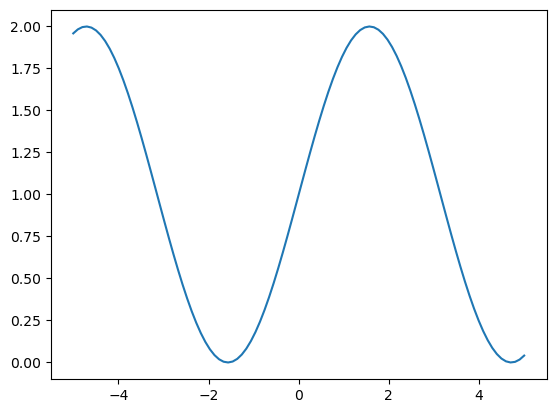

In [4]:
t1 = NP_Heap(length = 2)
t1.heap[0] = Function_node('ERR')
t1.heap[1] = Function_node('+')
t1.insert(parent_indx = 1,position= 'L', node_obj = Function_node('sin'))
t1.insert(parent_indx = 1,position= 'R', node_obj = Function_node('const', value = 1))
t1.insert(parent_indx = 2,position= 'L', node_obj = Function_node('var'))
#t1.insert(parent_indx = 2,position= 'R', node_obj = Function_node('var'))
#t1.insert(parent_indx = 3,position= 'R', node_obj = Function_node('const', value = 3.14))



t1.evaluate(X= 0)
x_arr = np.linspace(-5,5,100)

y = [t1.evaluate(X = x) for x in x_arr]
t1.heap[6] = None
t1.print_arr()
plt.plot(x_arr,y)